 # <h2><center><strong style="color:#ff6161"> Detecting Linux system hacking activities Part B
 </center></strong></h3>
 

<h3> 1. SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone.


In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

#Importing essential packages for the Spark Streaming Conf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
#from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import PipelineModel
import time
import matplotlib.pyplot as plt
%matplotlib notebook

# Setting Spark Conf
spark_conf = SparkConf().setMaster('local[2]').setAppName("Hacking Analysiss in Spark").set("spark.sql.session.timeZone", "UTC")

# Creating Spark Instance
spark = SparkSession \
    .builder \
    .config(conf=spark_conf) \
    .getOrCreate()


<h3> 2. From the Kafka producers in Task 1.1 and 1.2, ingest the streaming data into Spark Streaming for both process and memory activities(3%)


In [2]:
#Setting the memory topic and Spark Readstream for Kafka Server
memory_topic = 'mem_pop_x4'
memory_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", memory_topic) \
    .load()

#Setting the process topic and Spark Readstream for Kafka Server
process_topic = 'processaa12'
process_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", process_topic) \
    .load()

<h3> Displaying the Schema for both the dataframes read : 

In [3]:
memory_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
process_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



<h4> Selecting and casting the Key and value in the data frame:

In [5]:
memory_df = memory_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)") 
process_df = process_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [6]:
memory_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



In [7]:
process_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



<p><strong style="color:#2a52be"> Here, since we are receiving data as an  array of arrays, <code>ArrayType</code> of <code>ArrayType</code> is used while defining our schema.

Defining the schema for Memory and Process data frame based partially on the metadata. 
    
 </strong>

In [8]:
customSchema_memory = ArrayType(ArrayType(StructType([   
    StructField("sequence", IntegerType(), True),
    StructField("machine", IntegerType(), True),        
    StructField("PID", IntegerType(), True),
    StructField("MINFLT", StringType(), True),
    StructField("MAJFLT", StringType(), True),
    StructField("VSTEXT", StringType(), True),
    StructField("VSIZE", DoubleType(), True),
    StructField("RSIZE", StringType(), True),
    StructField("VGROW", StringType(), True),
    StructField("RGROW", StringType(), True),
    StructField("MEM", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("ts", StringType(), True)
])))

In [9]:
#Using the specified below schema to load the data to compile the schema
customSchema_process = ArrayType(ArrayType(StructType([
    StructField("sequence", IntegerType(), True),        
    StructField("machine", IntegerType(), True),
    StructField("PID", IntegerType(), True),
    StructField("TRUN", IntegerType(), True),
    StructField("TSLPI", IntegerType(), True),
    StructField("TSLPU", IntegerType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", IntegerType(), True),
    StructField("PRI", IntegerType(), True),
    StructField("RTPR", IntegerType(), True),
    StructField("CPUNR", IntegerType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", IntegerType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("ts", StringType(), True)
])))

<p><strong style="color:#2a52be"> Converting the value column cast to String and fitting the Schema and setting the alias to Parsed_value  </strong>

In [10]:
memory_df = memory_df.select(from_json(col("value").cast("string"), customSchema_memory).alias('parsed_value'))
process_df = process_df.select(from_json(col("value").cast("string"), customSchema_process).alias('parsed_value'))

In [11]:
memory_df.printSchema()

root
 |-- parsed_value: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- sequence: integer (nullable = true)
 |    |    |    |-- machine: integer (nullable = true)
 |    |    |    |-- PID: integer (nullable = true)
 |    |    |    |-- MINFLT: string (nullable = true)
 |    |    |    |-- MAJFLT: string (nullable = true)
 |    |    |    |-- VSTEXT: string (nullable = true)
 |    |    |    |-- VSIZE: double (nullable = true)
 |    |    |    |-- RSIZE: string (nullable = true)
 |    |    |    |-- VGROW: string (nullable = true)
 |    |    |    |-- RGROW: string (nullable = true)
 |    |    |    |-- MEM: double (nullable = true)
 |    |    |    |-- CMD: string (nullable = true)
 |    |    |    |-- ts: string (nullable = true)



In [12]:
process_df.printSchema()

root
 |-- parsed_value: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- sequence: integer (nullable = true)
 |    |    |    |-- machine: integer (nullable = true)
 |    |    |    |-- PID: integer (nullable = true)
 |    |    |    |-- TRUN: integer (nullable = true)
 |    |    |    |-- TSLPI: integer (nullable = true)
 |    |    |    |-- TSLPU: integer (nullable = true)
 |    |    |    |-- POLI: string (nullable = true)
 |    |    |    |-- NICE: integer (nullable = true)
 |    |    |    |-- PRI: integer (nullable = true)
 |    |    |    |-- RTPR: integer (nullable = true)
 |    |    |    |-- CPUNR: integer (nullable = true)
 |    |    |    |-- Status: string (nullable = true)
 |    |    |    |-- EXC: integer (nullable = true)
 |    |    |    |-- State: string (nullable = true)
 |    |    |    |-- CPU: double (nullable = true)
 |    |    |    |-- CMD: string (nullable = true)
 |    |    |    |

<p><strong style="color:#2a52be"> As seen the schema above, the <strong>Columns</strong> are nested. So explode can be used to flatten it out. And since it's an nested array it will have to be exploded twice. 

In [13]:
memory_df = memory_df.select(explode(col("parsed_value")).alias('unnested_value')) 
process_df = process_df.select(explode(col("parsed_value")).alias('unnested_value'))      

In [14]:
memory_df = memory_df.select(explode(col("unnested_value")).alias('unnested_value')) 
process_df = process_df.select(explode(col("unnested_value")).alias('unnested_value'))      

<p><strong style="color:#2a52be"> After explode the data can be used to to apply queries. However, changing the column access name would be more feasible.

In [15]:
memory_df.printSchema()

root
 |-- unnested_value: struct (nullable = true)
 |    |-- sequence: integer (nullable = true)
 |    |-- machine: integer (nullable = true)
 |    |-- PID: integer (nullable = true)
 |    |-- MINFLT: string (nullable = true)
 |    |-- MAJFLT: string (nullable = true)
 |    |-- VSTEXT: string (nullable = true)
 |    |-- VSIZE: double (nullable = true)
 |    |-- RSIZE: string (nullable = true)
 |    |-- VGROW: string (nullable = true)
 |    |-- RGROW: string (nullable = true)
 |    |-- MEM: double (nullable = true)
 |    |-- CMD: string (nullable = true)
 |    |-- ts: string (nullable = true)



In [16]:
process_df.printSchema()

root
 |-- unnested_value: struct (nullable = true)
 |    |-- sequence: integer (nullable = true)
 |    |-- machine: integer (nullable = true)
 |    |-- PID: integer (nullable = true)
 |    |-- TRUN: integer (nullable = true)
 |    |-- TSLPI: integer (nullable = true)
 |    |-- TSLPU: integer (nullable = true)
 |    |-- POLI: string (nullable = true)
 |    |-- NICE: integer (nullable = true)
 |    |-- PRI: integer (nullable = true)
 |    |-- RTPR: integer (nullable = true)
 |    |-- CPUNR: integer (nullable = true)
 |    |-- Status: string (nullable = true)
 |    |-- EXC: integer (nullable = true)
 |    |-- State: string (nullable = true)
 |    |-- CPU: double (nullable = true)
 |    |-- CMD: string (nullable = true)
 |    |-- ts: string (nullable = true)



<p><strong style="color:#2a52be"> Setting an alias to the structured column for easy transformations. 

In [17]:
df_memory_formatted = memory_df.select(
                    col("unnested_value.sequence").alias("sequence"),
                    col("unnested_value.machine").alias("machine"),
                    col("unnested_value.PID").alias("PID"),
                    col("unnested_value.MINFLT").alias("MINFLT"),
                    col("unnested_value.MAJFLT").alias("MAJFLT"),
                    col("unnested_value.VSTEXT").alias("VSTEXT"),
                    col("unnested_value.VSIZE").alias("VSIZE"),
                    col("unnested_value.RSIZE").alias("RSIZE"),
                    col("unnested_value.VGROW").alias("VGROW"),
                    col("unnested_value.RGROW").alias("RGROW"),
                    col("unnested_value.MEM").alias("MEM"),
                    col("unnested_value.CMD").alias("CMD"),
                    col("unnested_value.ts").alias("ts")
                )

In [18]:
df_process_formatted = process_df.select(
                    col("unnested_value.sequence").alias("sequence"),
                    col("unnested_value.machine").alias("machine"),
                    col("unnested_value.PID").alias("PID"),
                    col("unnested_value.TRUN").alias("TRUN"),
                    col("unnested_value.TSLPI").alias("TSLPI"),
                    col("unnested_value.TSLPU").alias("TSLPU"),
                    col("unnested_value.POLI").alias("POLI"),
                    col("unnested_value.NICE").alias("NICE"),
                    col("unnested_value.PRI").alias("PRI"),
                    col("unnested_value.RTPR").alias("RTPR"),
                    col("unnested_value.CPUNR").alias("CPUNR"),
                    col("unnested_value.Status").alias("Status"),
                    col("unnested_value.EXC").alias("EXC"),
                    col("unnested_value.State").alias("State"),
                    col("unnested_value.CPU").alias("CPU"),
                    col("unnested_value.CMD").alias("CMD"),
                    col("unnested_value.ts").alias("ts")
                 )

<p><strong style="color:#2a52be"> The final formatted data frame, is as follows: 

In [19]:
df_memory_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)



In [20]:
df_process_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)



<p><strong style="color:#2a52be"> Checking if data is read into the data frame by viewing the streamed data in console. 

In [21]:
def foreach_batch_function(df, epoch_id):
    df.show(20,False)


In [22]:
#Reading the streamed data in append output mode in console format
memory_df_op = df_memory_formatted.writeStream\
        .outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .format("console")\
        .start()

In [23]:
#Stop the query after checking
memory_df_op.stop()

In [24]:
#Reading the streamed data in append output mode in console format
process_df_op = df_process_formatted.writeStream\
        .outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .format("console")\
        .start()

In [25]:
#Stop the query after checking
process_df_op.stop()

<h3> 3. Then the streaming data format should be transformed into the proper formats following the metadata file schema for both process and memory

<h3> The numeric values with extra spaces or “K” / “M” / “G” should be properly transformed into their correct values

<p><strong style="color:#2a52be"> Checking the columns for transformation based on the previous information.

In [26]:
#Replacing the fields which include K, M, G With the corresponding numeric values of 10^3,10^6 and 10^9
memoryDF = df_memory_formatted.withColumn('MINFLT', regexp_replace('MINFLT', 'K', '000'))
memoryDF = memoryDF.withColumn('MAJFLT', regexp_replace('MAJFLT', 'K', '000'))
memoryDF = memoryDF.withColumn('VSTEXT', regexp_replace('VSTEXT', 'K', '000'))
memoryDF = memoryDF.withColumn('RSIZE', regexp_replace('RSIZE', 'K', '000'))
memoryDF = memoryDF.withColumn('VGROW', regexp_replace('VGROW', 'K', '000'))
memoryDF = memoryDF.withColumn('RGROW', regexp_replace('RGROW', 'K', '000'))
memoryDF = memoryDF.withColumn('MINFLT', regexp_replace('MINFLT', 'G', '000000000'))
memoryDF = memoryDF.withColumn('MAJFLT', regexp_replace('MAJFLT', 'G', '000000000'))
memoryDF = memoryDF.withColumn('VSTEXT', regexp_replace('VSTEXT', 'G', '000000000'))
memoryDF = memoryDF.withColumn('RSIZE', regexp_replace('RSIZE', 'G', '000000000'))
memoryDF = memoryDF.withColumn('VGROW', regexp_replace('VGROW', 'G', '000000000'))
memoryDF = memoryDF.withColumn('RGROW', regexp_replace('RGROW', 'G', '000000000'))

# Values with decimal converted to correctly represent the value 
memoryDF = memoryDF.withColumn('MAJFLT', regexp_replace('MAJFLT', '.2M', '200000')) 
memoryDF = memoryDF.withColumn('MAJFLT', regexp_replace('MAJFLT', '.4M', '400000'))
memoryDF = memoryDF.withColumn('RSIZE', regexp_replace('RSIZE', '.2M', '200000')) 
memoryDF = memoryDF.withColumn('RSIZE', regexp_replace('RSIZE', '.4M', '400000'))

#Removing the space in between some values
memoryDF = memoryDF.withColumn('VGROW', regexp_replace('VGROW', ' ', ''))
memoryDF = memoryDF.withColumn('RGROW', regexp_replace('RGROW', ' ', ''))

<p><strong style="color:#2a52be"> Casting the column to match the metadata specifications. 

In [27]:
#Casting the data to the required schema from the metadata

memoryDF = memoryDF.withColumn("MINFLT", col("MINFLT").cast('long'))
memoryDF = memoryDF.withColumn("MAJFLT", col("MAJFLT").cast('double'))
memoryDF = memoryDF.withColumn("VSTEXT", col("VSTEXT").cast('double'))
memoryDF = memoryDF.withColumn("RSIZE", col("RSIZE").cast('double'))
memoryDF = memoryDF.withColumn("VGROW", col("VGROW").cast('double'))
memoryDF = memoryDF.withColumn("RGROW", col("RGROW").cast('double'))

<h3> 3. b. The NICE value should also be restored based on the PRI values using their relationship

In [28]:
df_process_formatted = df_process_formatted.withColumn("NICE", when((col("PRI") == 100), -20)\
                                                      .when((col("PRI") == 109),-11)\
                                                       .when((col("PRI") == 120),0)\
                                                      .when((col("PRI") == 121),1)\
                                                      .when((col("PRI") == 130),10)\
                                                      .when((col("PRI") == 139),19)\
                                                      .otherwise(0))

<h3> 4. For process and memory, respectively, create a new column “CMD_PID” concatenating “CMD” and “PID” columns, and a new column “event_time” as timestamp format based on the unix time in “ts” column (5%)
    
- Allow 20-second tolerance for possible data delay on “event_time” using watermarking

In [29]:
#Concatenating the memory data frame with CMD and PID
memoryDF = memoryDF.withColumn('CMD_PID', 
                    concat(col('CMD'),lit('_'), col('PID')))

#Concatenating the process data frame with CMD and PID
processDF = df_process_formatted.withColumn('CMD_PID', 
                    concat(col('CMD'),lit('_'), col('PID')))

In [30]:
#Adding the event timestamp with by converting the unix timestamp ts column
memoryDF = memoryDF.withColumn('event_time', from_utc_timestamp(from_unixtime(col("ts")),'UTC')) #,"MM-dd-yyyy HH:mm:ss"))
#Casting the event time to timestamp
memoryDF = memoryDF.withColumn("event_time", col("event_time").cast("timestamp"))
#Adding  watermark to the event time column by 20 seconds
memoryDF = memoryDF.withWatermark("event_time", "20 seconds")

In [31]:
memoryDF.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: long (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)



In [32]:
#Checking for the output in memory dataframe
memory_op = memoryDF.writeStream\
        .outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .format("console")\
        .start()

In [33]:
memory_op.stop()

In [34]:
#Adding the event timestamp with by converting the unix timestamp ts column
processDF = processDF.withColumn('event_time',from_unixtime('ts')) #.cast(TimestampType()))
#Casting the event time to timestamp
processDF = processDF.withColumn("event_time", col("event_time").cast("timestamp"))
#Adding  watermark to the event time column by 20 seconds
processDF = processDF.withWatermark('event_time', '20 seconds')

In [35]:
#Checking for the output in memory dataframe
process_op = processDF.writeStream\
        .outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .format("console")\
        .start()

In [36]:
process_op.stop()

<h3> 5. Persist the transformed streaming data in parquet format for both process and memory. 
- The process data should be stored in “process.parquet” in the same folder of your notebook, and the memory data should be stored in “memory.parquet” in
the same folder of your notebook

In [37]:
#Persisting the transformed memory data frame in parquet format
memory_sink_parquet = memoryDF.writeStream.format('parquet')\
                    .outputMode('append')\
                    .option('path', 'memory.parquet/memoryDF')\
                    .option('checkpointLocation', 'memory.parquet/memoryDF/checkpoint')\
                    .start()

In [38]:
#Persisting the transformed process data frame in parquet format
process_sink_parquet = processDF.writeStream.format('parquet')\
                    .outputMode('append')\
                    .option('path', 'process.parquet/processDF')\
                    .option('checkpointLocation', 'process.parquet/processDF/checkpoint')\
                    .start()

<h3>6. Load the machine learning models given , and use the models to predict whether each process or memory streaming record is an attack event, respectively 

In [39]:
#Loading the Pipeline model from file
pipelineModel_memory = PipelineModel.load('memory_pipeline_model')
pipelineModel_process = PipelineModel.load('process_pipeline_model')

In [40]:
#Transforming the memory and process dataframe using the pipeline memory model
predictions_memory_model = pipelineModel_memory.transform(memoryDF)
predictions_processmodel = pipelineModel_process.transform(processDF)

In [41]:
#Checking for if each process and memory streaming data is an attack using the prediction
pred_memory_attack = predictions_memory_model.filter(col('prediction') == 1.0)
pred_process_attack = predictions_processmodel.filter(col('prediction') == 1.0)

In [42]:
#Batch function for data frame
def foreach_batch_function(df, epoch_id):
    df.show(20,False)

In [43]:
#Reading the streamed data in append output mode in console format
pred_memory_op = pred_memory_attack.writeStream\
        .outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .format("console")\
        .start()

In [44]:
pred_memory_op.stop()

<h3> 7 a. If any program in one machine is predicted as an attack in EITHER process or memory activity prediction, it could be a false alarm or a potential attack. Keep track of the approximate count of such events in every 2-min window for each machine for process and memory, respectively, and write the stream into Spark Memory sink using complete mode.


<p><strong style="color:#2a52be"> Checking for attacks between the two minute window and count approximate distinct for CMD_PID column for each MACHINE in the window  </strong>

In [45]:
prediction_memory_attack_all = pred_memory_attack.groupBy('machine', window(pred_memory_attack.event_time, '119 seconds'))\
                                .agg(approx_count_distinct('CMD_PID').alias('count')).select("machine","window","count")

In [46]:
prediction_process_attack_all = pred_process_attack.groupBy('machine', window(pred_process_attack.event_time, '119 seconds'))\
                                .agg(approx_count_distinct('CMD_PID').alias('count')).select("machine","window","count")

<p><strong style="color:#2a52be"> Checking for prediction records for memory and process displaying it on the notebook : 

In [64]:
#Reading the streamed data in complete output mode 
memory_attack_approx = prediction_memory_attack_all.writeStream\
        .outputMode("complete")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .start()

+-------+------+-----+
|machine|window|count|
+-------+------+-----+
+-------+------+-----+

+-------+------------------------------------------+-----+
|machine|window                                    |count|
+-------+------------------------------------------+-----+
|4      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|32   |
|6      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|12   |
|7      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|21   |
|5      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|14   |
|8      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|6    |
+-------+------------------------------------------+-----+

+-------+------------------------------------------+-----+
|machine|window                                    |count|
+-------+------------------------------------------+-----+
|4      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|93   |
|6      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|48   |
|7      |[2020-11-01 01:01:11, 2020-11-01 01:03:10]|36   |
|5      |[2020-11-01 

In [65]:
memory_attack_approx.stop()

In [72]:
#Reading the streamed data in complete output mode 
process_attack_approx1 = prediction_process_attack_all.writeStream\
        .outputMode("complete")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .start()    

+-------+------------------------------------------+-----+
|machine|window                                    |count|
+-------+------------------------------------------+-----+
|7      |[2020-11-01 01:03:10, 2020-11-01 01:05:09]|70   |
|5      |[2020-11-01 01:03:10, 2020-11-01 01:05:09]|250  |
|6      |[2020-11-01 01:05:09, 2020-11-01 01:07:08]|48   |
|6      |[2020-11-01 01:03:10, 2020-11-01 01:05:09]|95   |
|8      |[2020-11-01 01:03:10, 2020-11-01 01:05:09]|154  |
|5      |[2020-11-01 01:05:09, 2020-11-01 01:07:08]|98   |
|7      |[2020-11-01 01:05:09, 2020-11-01 01:07:08]|68   |
|8      |[2020-11-01 01:05:09, 2020-11-01 01:07:08]|50   |
+-------+------------------------------------------+-----+

+-------+------------------------------------------+-----+
|machine|window                                    |count|
+-------+------------------------------------------+-----+
|6      |[2020-11-01 01:05:09, 2020-11-01 01:07:08]|81   |
|5      |[2020-11-01 01:05:09, 2020-11-01 01:07:08]|110

In [76]:
process_attack_approx1.stop()

<p><strong style="color:#2a52be"> Creating a memory sink for both the process and memory using complete mode : 

In [51]:
#Reading the streamed data in append outut mode in append format storing in queryname instance
prediction_memory_attack_all_sink = prediction_memory_attack_all.writeStream\
        .outputMode("complete")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .queryName("prediction_memory_attack_all_approx1")\
        .format("memory")\
        .start()

In [52]:
#Reading the streamed data in append outut mode in append format storing in queryname instance
prediction_process_attack_all_sink = prediction_process_attack_all.writeStream\
        .outputMode("complete")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .queryName("prediction_process_attack_all_approx1")\
        .format("memory")\
        .start()

<h3> 7) b. If a program in one machine, having the same “CMD” and “PID” in both process and memory streaming data, is predicted as an attack in BOTH
process and memory activity prediction, then this is considered as an attack event. Find the streaming events fulfilling the criteria, create a new column to
record the processing time and persist them in parquet.
- Note the program with the same “CMD” and “PID” might not be
generated at the exact same event time. If the difference between the
event times in process and memory is less than 30 seconds and the
program fulfills the criteria of matching “CMD” and “PID”, then you
should include them for the above checking.


<p><strong style="color:#2a52be"> Renaming the prediction memory attack data frame then joined on CMD_PID and the difference between the event time process and memory and filter the difference less than 30 with current processing time. </strong>

In [53]:
memoryDF_sub = pred_memory_attack.withColumnRenamed("sequence", "sequence_memory")\
                    .withColumnRenamed("machine", "machine_memory")\
                    .withColumnRenamed("PID", "PID_memory")\
                    .withColumnRenamed("CMD", "CMD_memory")\
                    .withColumnRenamed("CMD_PID", "CMD_PID_memory")\
                    .withColumnRenamed("MINFLT","MINFLT_memory")\
                    .withColumnRenamed("MAJFLT","MAJFLT_memory")\
                    .withColumnRenamed("VSTEXT","VSTEXT_memory")\
                    .withColumnRenamed("VSIZE","VSIZE_memory")\
                    .withColumnRenamed("RSIZE","RSIZE_memory")\
                    .withColumnRenamed("VGROW","VGROW_memory")\
                    .withColumnRenamed("RGROW","RGROW_memory")\
                    .withColumnRenamed("MEM","MEM_memory")\
                    .withColumnRenamed("ts","ts_memory")\
                    .withColumnRenamed("event_time", "event_time_memory")\
                    .withColumnRenamed("prediction", "prediction_memory")
    
processDF_sub = pred_process_attack.withColumnRenamed("sequence", "sequence_process")\
                    .withColumnRenamed("machine", "machine_process")\
                    .withColumnRenamed("PID", "PID_process")\
                    .withColumnRenamed("TRUN", "TRUN_process")\
                    .withColumnRenamed("TSLPI", "TSLPI_process")\
                    .withColumnRenamed("TSLPU", "TSLPU_process")\
                    .withColumnRenamed("POLI", "POLI_process")\
                    .withColumnRenamed("NICE", "NICE_process")\
                    .withColumnRenamed("PRI", "PRI_process")\
                    .withColumnRenamed("RTPR", "RTPR_process")\
                    .withColumnRenamed("CPUNR", "CPUNR_process")\
                    .withColumnRenamed("Status", "Status_process")\
                    .withColumnRenamed("EXC", "EXC_process")\
                    .withColumnRenamed("State", "State_process")\
                    .withColumnRenamed("CPU", "CPU_process")\
                    .withColumnRenamed("CMD", "CMD_process")\
                    .withColumnRenamed("CMD_PID", "CMD_PID_process")\
                    .withColumnRenamed("ts", "ts_process")\
                    .withColumnRenamed("event_time", "event_time_process")\
                    .withColumnRenamed("prediction", "prediction_process")

joinDF = processDF_sub.join(memoryDF_sub,expr("""CMD_PID_process == CMD_PID_memory AND  machine_memory = machine_process """),"inner")\
            .withColumn("Difference", abs((col("event_time_memory").cast("long") - col("event_time_process").cast("long"))))\
            .select("sequence_memory","machine_memory","PID_memory","CMD_memory","CMD_PID_memory","MINFLT_memory",\
                    "MAJFLT_memory","VSTEXT_memory","VSIZE_memory","RSIZE_memory","VGROW_memory","RGROW_memory",\
                    "MEM_memory","ts_memory","event_time_memory","prediction_memory",\
                    "sequence_process","machine_process","PID_process","TRUN_process","TSLPI_process","TSLPU_process",\
                    "POLI_process","NICE_process","PRI_process","RTPR_process","CPUNR_process","Status_process",\
                    "EXC_process","State_process","CPU_process","CMD_process","CMD_PID_process","ts_process","event_time_process",\
                    "prediction_process","Difference")


joinDF_fin = joinDF.filter(joinDF.Difference < 30)\
                .withColumn("processing_time", current_timestamp())\
                .select("sequence_memory","machine_memory","PID_memory","CMD_memory","CMD_PID_memory","MINFLT_memory",\
                    "MAJFLT_memory","VSTEXT_memory","VSIZE_memory","RSIZE_memory","VGROW_memory","RGROW_memory",\
                    "MEM_memory","ts_memory","event_time_memory","prediction_memory",\
                    "sequence_process","machine_process","PID_process","TRUN_process","TSLPI_process","TSLPU_process",\
                    "POLI_process","NICE_process","PRI_process","RTPR_process","CPUNR_process","Status_process",\
                    "EXC_process","State_process","CPU_process","CMD_process","CMD_PID_process","ts_process","event_time_process",\
                    "prediction_process")

In [54]:
#Reading the streamed data in append output mode in append format storing in queryname
joinDF_op = joinDF_fin.writeStream\
        .outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .format("console")\
        .start()

In [52]:
#Reading the streamed data in append outut mode in append format storing in queryname instance
joinDF_op = joinDF_fin.writeStream\
        .outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .queryName("joinDF_fin")\
        .format("memory")\
        .start()

In [55]:
joinDF_op.stop()

<h3> 7 b. Persist the program’s relevant information (including process & memory data, process & memory’s event and processing timestamp, and prediction result) into parquet format with the name of “process_memory_attack.parquet”

In [56]:
#Persisting the combined data for memory and process in parquet format in append output mode in memory sink
process_memory_attack_sink_ = joinDF_fin.writeStream.format('parquet')\
                    .outputMode('append')\
                    .option('path', 'process_memory_attack.parque/joinDF_fin')\
                    .option('checkpointLocation', 'process_memory_attack.parque/joinDF_fin/checkpoint')\
                    .start()

<h3> 8. Visualise the data in line charts for step 7a 

For the count of suspect attacks for each machine in step 7a, use Spark SQL to query the data from Spark Memory sink, and prepare a line chart plot for showing the count of suspect attacks for each machine at each 2-min window from the start to the most recent, and refresh the plot every 10 minutes.

In [57]:
#Defining the plot characteristics 
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    

<IPython.core.display.Javascript object>


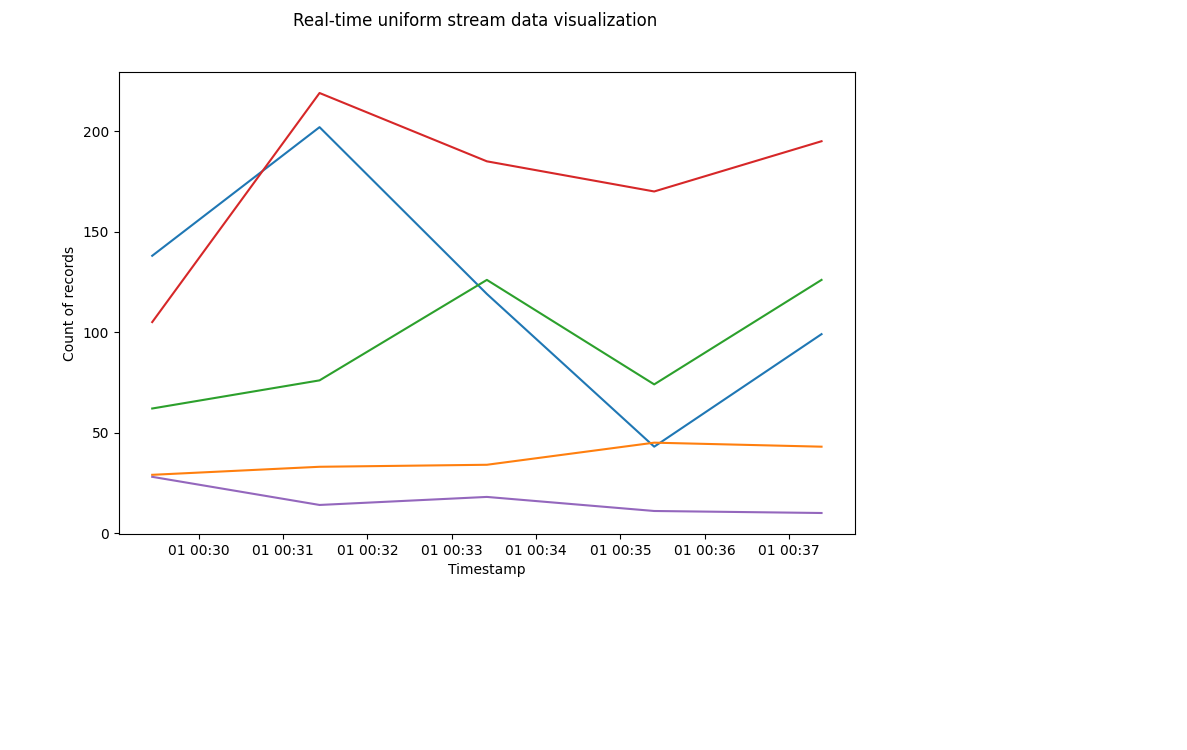

KeyboardInterrupt: 

In [59]:
#Function to create plots for the suspect counts from the memory sink
fig, ax = init_plots()
while True:
    #Reinitializing the lists for count and timestamp
    x4,x5,x6,x7,x8,y4,y5,y6,y7,y8 = [],[],[],[],[],[],[],[],[],[]
    #Querying for each machine data and retreiving the window end time to be used as the X axis and the count as the Y axis
    machine4_df = spark.sql(''' select window.end as end_time, machine,count from prediction_memory_attack_all_approx1 where machine = 4 order by end_time''').toPandas()
    machine5_df = spark.sql(''' select window.end as end_time, machine,count from prediction_memory_attack_all_approx1 where machine = 5 order by end_time''').toPandas()
    machine6_df = spark.sql(''' select window.end as end_time, machine,count from prediction_memory_attack_all_approx1 where machine = 6 order by end_time''').toPandas()
    machine7_df = spark.sql(''' select window.end as end_time, machine,count from prediction_memory_attack_all_approx1 where machine = 7 order by end_time''').toPandas()
    machine8_df = spark.sql(''' select window.end as end_time, machine,count from prediction_memory_attack_all_approx1 where machine = 8 order by end_time''').toPandas()
    
    #Converting the pandas dataframe to list
    x4 = machine4_df['end_time'].to_list()
    y4 = machine4_df['count'].to_list()
    x5 = machine5_df['end_time'].to_list()
    y5 = machine5_df['count'].to_list()
    x6 = machine6_df['end_time'].to_list()
    y6 = machine6_df['count'].to_list()
    x7 = machine7_df['end_time'].to_list()
    y7 = machine7_df['count'].to_list()
    x8 = machine8_df['end_time'].to_list()
    y8 = machine8_df['count'].to_list()
    
    #Plotting the count for each window end timestamp
    ax.clear()
    ax.plot(x4,y4)
    ax.plot(x5,y5)
    ax.plot(x6,y6)
    ax.plot(x7,y7)
    ax.plot(x8,y8)
    
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count of records')
    fig.canvas.draw()
    
    #Refreshing the plot every 10 minutes
    time.sleep(600)
    
    
    

<IPython.core.display.Javascript object>


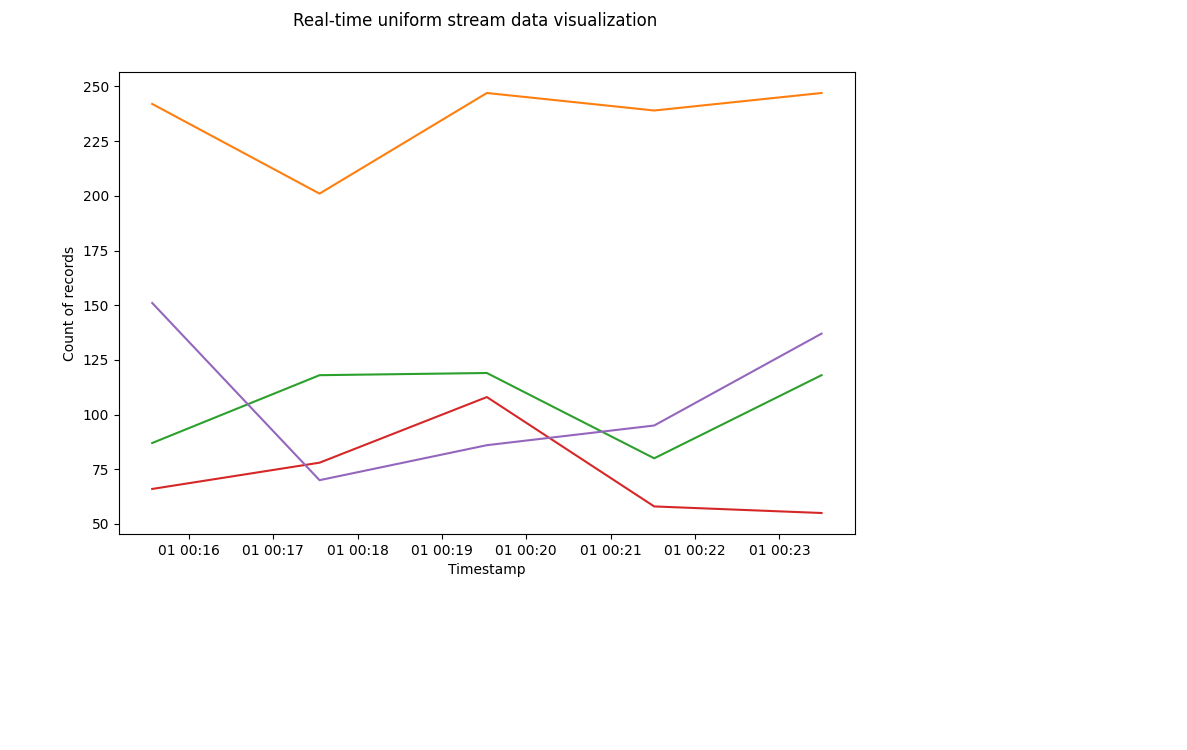

KeyboardInterrupt: 

In [58]:
#Function to create plots for the suspect counts from the memory sink

fig, ax = init_plots()
while True: 
    #Reinitializing the lists for count and timestamp
    x4,x5,x6,x7,x8,y4,y5,y6,y7,y8 = [],[],[],[],[],[],[],[],[],[]
    #Querying for each machine data and retreiving the window end time to be used as the X axis and the count as the Y axis
    machine4_df = spark.sql(''' select window.end as end_time, machine,count from prediction_process_attack_all_approx1 where machine = 4 order by end_time''').toPandas()
    machine5_df = spark.sql(''' select window.end as end_time, machine,count from prediction_process_attack_all_approx1 where machine = 5 order by end_time''').toPandas()
    machine6_df = spark.sql(''' select window.end as end_time, machine,count from prediction_process_attack_all_approx1 where machine = 6 order by end_time''').toPandas()
    machine7_df = spark.sql(''' select window.end as end_time, machine,count from prediction_process_attack_all_approx1 where machine = 7 order by end_time''').toPandas()
    machine8_df = spark.sql(''' select window.end as end_time, machine,count from prediction_process_attack_all_approx1 where machine = 8 order by end_time''').toPandas()
    
    #Converting the pandas dataframe to list
    x4 = machine4_df['end_time'].to_list()
    y4 = machine4_df['count'].to_list()
    x5 = machine5_df['end_time'].to_list()
    y5 = machine5_df['count'].to_list()
    x6 = machine6_df['end_time'].to_list()
    y6 = machine6_df['count'].to_list()
    x7 = machine7_df['end_time'].to_list()
    y7 = machine7_df['count'].to_list()
    x8 = machine8_df['end_time'].to_list()
    y8 = machine8_df['count'].to_list()
    
    #Plotting the count for each window end timestamp
    ax.clear()
    ax.plot(x4,y4)
    ax.plot(x5,y5)
    ax.plot(x6,y6)
    ax.plot(x7,y7)
    ax.plot(x8,y8)
    
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count of records')
    fig.canvas.draw()
    
    #Refreshing the plot every 10 minutes
    time.sleep(600)
    
    
    